In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

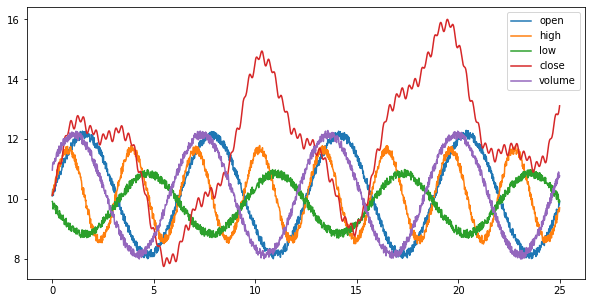

In [34]:
num_datapoints = 1500

t = torch.linspace(0, 25, num_datapoints)
open = 10 + 2 * torch.sin(t) + 0.3 * torch.rand(t.shape)
high = 10 + 1.5 * torch.sin(2 * t) + 0.3 * torch.rand(t.shape)
low = 10 + torch.sin(-t) - 0.3 * torch.rand(t.shape)
close = 10 + 2.5 * torch.sin(0.75 * t) + 0.75 * torch.sin(2 * t) + 0.15 * t + 0.1 * torch.sin(10 * t) + 0.15 * torch.sin(20 * t + 2) 
volume = 10 + 2 * torch.sin(t + 0.5) + 0.3 * torch.rand(t.shape)
time_index = torch.arange(1, num_datapoints + 1, 1)

plt.figure(figsize=(10, 5))
plt.plot(t, open, label='open')
plt.plot(t, high, label='high')
plt.plot(t, low, label='low')
plt.plot(t, close, label='close')
plt.plot(t, volume, label='volume')
plt.legend();
# will be attempting to predict the change in close price

In [35]:
X = torch.stack([time_index, open, high, low, close, volume], dim=1)
X.shape

torch.Size([1500, 6])

In [36]:
y = torch.tensor([(b - a) / a for a, b in zip(close[:-1], close[1:])])
y.shape

torch.Size([1499])

In [37]:
# need to drop the very first value of X and t
X = X[1:]
t = t[1:]

In [38]:
train_split = int(0.8 * len(X))
test_split = int(0.9 * len(X))

X_train, X_test, X_val = X[:train_split], X[train_split:test_split], X[test_split:]
y_train, y_test, y_val = y[:train_split], y[train_split:test_split], y[test_split:]

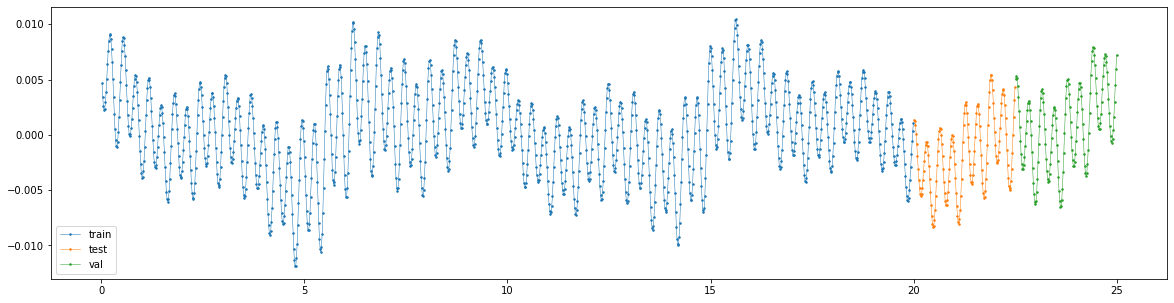

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(t[:train_split], y_train, label='train', linewidth=0.5, marker='.', markersize=3)
plt.plot(t[train_split:test_split], y_test, label='test', linewidth=0.5, marker='.', markersize=3)
plt.plot(t[test_split:], y_val, label='val', linewidth=0.5, marker='.', markersize=3)
plt.legend();
# here are our splits and what we are trying to predict

In [40]:
# this is just a toy model and the only thing that affects the target is the close price
# the hope being that the model will realise this and learn to predict the change in close price

In [42]:
# input_shape = (32, 128, 6) - batch_size, sequence_length, features

In [50]:
# we begin by teaching the model what time means
# this will be done with a time embedding layer following the Time2Vec paper with a slight modification

class TimeVec(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.linear_time = nn.Linear(seq_len, seq_len)
        self.periodic_time = nn.Linear(seq_len, seq_len)

    def forward(self, x):
        x = x[:, :, 0].view(-1, self.seq_len) # use only the time index
        linear_time = self.linear_time(x).view(-1, self.seq_len, 1)        
        periodic_time = torch.sin(self.periodic_time(x)).view(-1, self.seq_len, 1)
        return torch.cat([linear_time, periodic_time], dim=-1)

# the time vector is a 2D vector comprising of a linear and periodic component derived from the time index

In [51]:
test_batch = torch.rand(32, 128, 5)
m = TimeVec(128)
m(test_batch).shape

torch.Size([32, 128, 2])

In [52]:
# we are then dealing with 8 features for our model, the 5 original features, the time index and the 2 time components
# the input into the transformer encoder will be (batch_size, sequence_length, features) = (32, 128, 8)

In [54]:
# this is how we combine them
a = torch.rand(32, 128, 6)
b = torch.rand(32, 128, 2)
torch.cat([a, b], dim=-1).shape

torch.Size([32, 128, 8])

## The model I am shooting for

![](./architecture.png)

In [59]:
enc_in_dim = 512

inp = torch.rand(32, 128, 6)
time_vec = TimeVec(128)
cat = torch.cat([inp, time_vec(inp)], dim=-1)
lin = nn.Linear(8, enc_in_dim)
enc_in = lin(cat)
enc_in.shape

torch.Size([32, 128, 512])

In [63]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(SelfAttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        # Linear layers for the three components of the attention mechanism:
        # query, key, and value
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer to combine the attention-weighted values
        self.output_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, inputs, mask):
        # inputs is a tensor of shape (batch_size, sequence_length, hidden_size)
        # mask is a tensor of shape (batch_size, sequence_length)

        # Split the input into multiple heads
        batch_size, sequence_length, hidden_size = inputs.size()
        inputs = inputs.view(batch_size, sequence_length, self.num_heads, self.head_size)
        inputs = inputs.permute(0, 2, 1, 3)  # (batch_size, num_heads, sequence_length, head_size)
        print(inputs.shape)

        # Compute the query, key, and value for each head
        query = self.query_layer(inputs)  # (batch_size, num_heads, sequence_length, head_size)
        key = self.key_layer(inputs)  # (batch_size, num_heads, sequence_length, head_size)
        value = self.value_layer(inputs)  # (batch_size, num_heads, sequence_length, head_size)

        # Compute the attention weights
        attention_weights = torch.matmul(query, key.transpose(-1, -2))  # (batch_size, num_heads, sequence_length, sequence_length)
        attention_weights = attention_weights / (self.head_size ** 0.5)  # Scale the attention weights
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)  # Mask the attention weights using the mask
        attention_weights = nn.functional.softmax(attention_weights, dim=-1)  # Normalize the attention weights

        # Compute the attention-weighted values
        attention_weighted_values = torch.matmul(attention_weights, value)  # (batch_size, num_heads, sequence_length, head_size)

        # Concatenate the attention-weighted values across the heads and apply the output layer
        attention_weighted_values = attention_weighted_values.permute(0, 2, 1, 3).contiguous()  # (batch_size, sequence_length, num_heads, head_size)

        attention_weighted_values = attention_weighted_values.view(batch_size, sequence_length, self.hidden_size)  # (batch_size, sequence_length, hidden_size)
        output = self.output_layer(attention_weighted_values)  # (batch_size, sequence_length, hidden_size)

        return output, attention_weights

In [64]:
enc_in_dim = 512

inp = torch.rand(32, 128, 6)
time_vec = TimeVec(128)
cat = torch.cat([inp, time_vec(inp)], dim=-1)
lin = nn.Linear(8, enc_in_dim)
enc_in = lin(cat)

mask = torch.rand(32, 128) > 0.5

attn = SelfAttentionLayer(enc_in_dim, 8)
attn(enc_in, mask)

torch.Size([32, 8, 128, 64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32768x64 and 512x512)

In [41]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 5 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 1 # The number of output variables.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 128 # length of input given to encoder. Can have any integer value.
output_sequence_length = 3 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

In [133]:
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        dec_seq_len,
        batch_first=True,
        out_seq_len=58,
        max_seq_len=128,
        dim_val=512,
        n_encoder_layers=4,
        n_decoder_layers=4,
        n_heads=8,
        dropout_encoder=0.2,
        dropout_decoder=0.2,
        dropout_pos_enc=0.1,
        dim_feedforward_enc=2048,
        dim_feedforward_dec=2048,
        num_predicted_feats=1,
    ):
        super().__init__()
        self.dec_seq_len = dec_seq_len

        self.encoder_input_layer = nn.Linear(input_size, dim_val)

        self.decoder_input_layer = nn.Linear(num_predicted_feats, dim_val)

        self.linear_mapping = nn.Linear(dim_val, num_predicted_feats)

        self.positional_enc_layer = PositionalEncoding(dim_val, dropout=dropout_pos_enc, max_len=max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_enc,
            dropout=dropout_encoder,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_dec,
            dropout=dropout_decoder,
            batch_first=batch_first
        )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
        )

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        src = self.encoder(src)

        decoder_output = self.decoder_input_layer(tgt)
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
        )

        decoder_output = self.linear_mapping(decoder_output)

        return decoder_output

In [135]:
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads
)